# Q4. Variational Autoencoder (VAE)

## 4.1 Introduction
A Variational Autoencoder (VAE) is a generative deep learning model that learns to encode data into a continuous latent space and decode it back to reconstruct the input. In this task, we implement and analyze a VAE trained on the Fashion-MNIST dataset.

### Import Required Libraries

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.manifold import TSNE
from scipy.linalg import sqrtm
from torchvision.models import inception_v3
import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 4.2 Dataset Preparation

Load and preprocess the Fashion-MNIST dataset using PyTorch utilities. We normalize the data and create DataLoader instances for both training and testing with appropriate batch size.

In [18]:
# Hyperparameters
BATCH_SIZE = 128
LATENT_DIM = 2  # For visualization purposes
IMAGE_SIZE = 28 * 28

# Data transformation - normalize to [0, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    transform=transform, 
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    transform=transform, 
    download=True
)

# Create data loaders
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)

# Fashion-MNIST class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of batches (train): {len(train_loader)}")
print(f"Number of batches (test): {len(test_loader)}")

Training samples: 60000
Test samples: 10000
Batch size: 128
Number of batches (train): 469
Number of batches (test): 79


## 4.3 Model Architecture

Design and implement a Variational Autoencoder consisting of:
1. **Encoder**: Maps the input image to a latent representation defined by mean vector μ and log-variance vector log(σ²)
2. **Reparameterization Trick**: Uses z = μ + ϵ·σ with ϵ ~ N(0,I) to enable stochastic sampling with gradient backpropagation
3. **Decoder**: Reconstructs images from latent samples

In [19]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, hidden_dims=[512, 256]):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        encoder_layers = []
        input_dim = IMAGE_SIZE
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU()
            ])
            input_dim = hidden_dim
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_logvar = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        decoder_layers = []
        self.fc_decode = nn.Linear(latent_dim, hidden_dims[-1])
        
        hidden_dims_reversed = list(reversed(hidden_dims))
        for i in range(len(hidden_dims_reversed) - 1):
            decoder_layers.extend([
                nn.Linear(hidden_dims_reversed[i], hidden_dims_reversed[i+1]),
                nn.ReLU()
            ])
        
        decoder_layers.append(nn.Linear(hidden_dims_reversed[-1], IMAGE_SIZE))
        decoder_layers.append(nn.Sigmoid())  # Output in [0, 1]
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        """Encode input to latent parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: z = mu + eps * sigma"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        """Decode latent vector to reconstruction"""
        h = F.relu(self.fc_decode(z))
        reconstruction = self.decoder(h)
        return reconstruction
    
    def forward(self, x):
        """Forward pass through VAE"""
        mu, logvar = self.encode(x.view(-1, IMAGE_SIZE))
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar

# Initialize model
model = VAE(latent_dim=LATENT_DIM).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=256, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

Total parameters: 1068820


## 4.4 Loss Function

The VAE loss combines two terms:
- **Reconstruction Loss**: Measures pixel-wise similarity using Binary Cross-Entropy (BCE)
- **KL Divergence**: Encourages the latent distribution q(z|x) to approximate the standard normal prior p(z)

The objective: L = E_q(z|x)[log p(x|z)] - D_KL(q(z|x)||p(z))

**Role of each term:**
- Reconstruction loss ensures the decoder can faithfully reconstruct inputs from latent codes
- KL divergence regularizes the latent space to be continuous and structured, enabling smooth interpolation and sampling

In [20]:
def vae_loss(reconstruction, x, mu, logvar, beta=1.0):
    """
    VAE loss function with beta parameter
    
    Args:
        reconstruction: reconstructed images
        x: original images
        mu: mean of latent distribution
        logvar: log variance of latent distribution
        beta: weight for KL divergence term (default=1.0, beta-VAE when != 1.0)
    
    Returns:
        total_loss, reconstruction_loss, kl_divergence
    """
    # Reconstruction loss (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(reconstruction, x.view(-1, IMAGE_SIZE), reduction='sum')
    
    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss with beta weighting
    total_loss = BCE + beta * KLD
    
    return total_loss, BCE, KLD

# Test the loss function
sample_batch = next(iter(train_loader))[0][:5].to(device)
sample_recon, sample_mu, sample_logvar = model(sample_batch)
total, bce, kld = vae_loss(sample_recon, sample_batch, sample_mu, sample_logvar)
print(f"Sample losses - Total: {total.item():.2f}, BCE: {bce.item():.2f}, KLD: {kld.item():.2f}")

Sample losses - Total: 2725.41, BCE: 2725.36, KLD: 0.04


## 4.5 Training Procedure

Train the VAE model using Adam optimizer and track the total loss and its components over epochs.

In [21]:
def train_vae(model, train_loader, optimizer, epoch, beta=1.0, log_interval=100):
    """Train VAE for one epoch"""
    model.train()
    train_loss = 0
    train_bce = 0
    train_kld = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        reconstruction, mu, logvar = model(data)
        
        # Calculate loss
        loss, bce, kld = vae_loss(reconstruction, data, mu, logvar, beta)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()
        
        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\\t'
                  f'Loss: {loss.item() / len(data):.4f}')
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = train_bce / len(train_loader.dataset)
    avg_kld = train_kld / len(train_loader.dataset)
    
    return avg_loss, avg_bce, avg_kld


def test_vae(model, test_loader, beta=1.0):
    """Evaluate VAE on test set"""
    model.eval()
    test_loss = 0
    test_bce = 0
    test_kld = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            loss, bce, kld = vae_loss(reconstruction, data, mu, logvar, beta)
            test_loss += loss.item()
            test_bce += bce.item()
            test_kld += kld.item()
    
    avg_loss = test_loss / len(test_loader.dataset)
    avg_bce = test_bce / len(test_loader.dataset)
    avg_kld = test_kld / len(test_loader.dataset)
    
    return avg_loss, avg_bce, avg_kld


In [22]:
# Training hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3

# Initialize model and optimizer
model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Track losses
train_losses = []
train_bces = []
train_klds = []
test_losses = []
test_bces = []
test_klds = []

# Train the model
print("Starting training with beta=1.0...")
for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_bce, train_kld = train_vae(model, train_loader, optimizer, epoch)
    test_loss, test_bce, test_kld = test_vae(model, test_loader)
    
    train_losses.append(train_loss)
    train_bces.append(train_bce)
    train_klds.append(train_kld)
    test_losses.append(test_loss)
    test_bces.append(test_bce)
    test_klds.append(test_kld)
    
    print(f'====> Epoch: {epoch} Average train loss: {train_loss:.4f}, test loss: {test_loss:.4f}')

print("Training complete!")

Starting training with beta=1.0...
Epoch 1 [0/60000 (0%)]\tLoss: 545.2258
Epoch 1 [12800/60000 (21%)]\tLoss: 276.4566
Epoch 1 [25600/60000 (43%)]\tLoss: 274.0808
Epoch 1 [38400/60000 (64%)]\tLoss: 279.0854
Epoch 1 [51200/60000 (85%)]\tLoss: 280.0025
====> Epoch: 1 Average train loss: 287.9315, test loss: 271.0527
Epoch 2 [0/60000 (0%)]\tLoss: 258.6500
Epoch 2 [12800/60000 (21%)]\tLoss: 266.2574
Epoch 2 [25600/60000 (43%)]\tLoss: 269.5910
Epoch 2 [38400/60000 (64%)]\tLoss: 266.0531
Epoch 2 [51200/60000 (85%)]\tLoss: 252.6061
====> Epoch: 2 Average train loss: 266.8661, test loss: 265.8762
Epoch 3 [0/60000 (0%)]\tLoss: 258.0370
Epoch 3 [12800/60000 (21%)]\tLoss: 261.5834
Epoch 3 [25600/60000 (43%)]\tLoss: 249.3031
Epoch 3 [38400/60000 (64%)]\tLoss: 255.2695
Epoch 3 [51200/60000 (85%)]\tLoss: 257.9539
====> Epoch: 3 Average train loss: 263.6520, test loss: 264.2452
Epoch 4 [0/60000 (0%)]\tLoss: 253.6145
Epoch 4 [12800/60000 (21%)]\tLoss: 261.3958
Epoch 4 [25600/60000 (43%)]\tLoss: 267.379

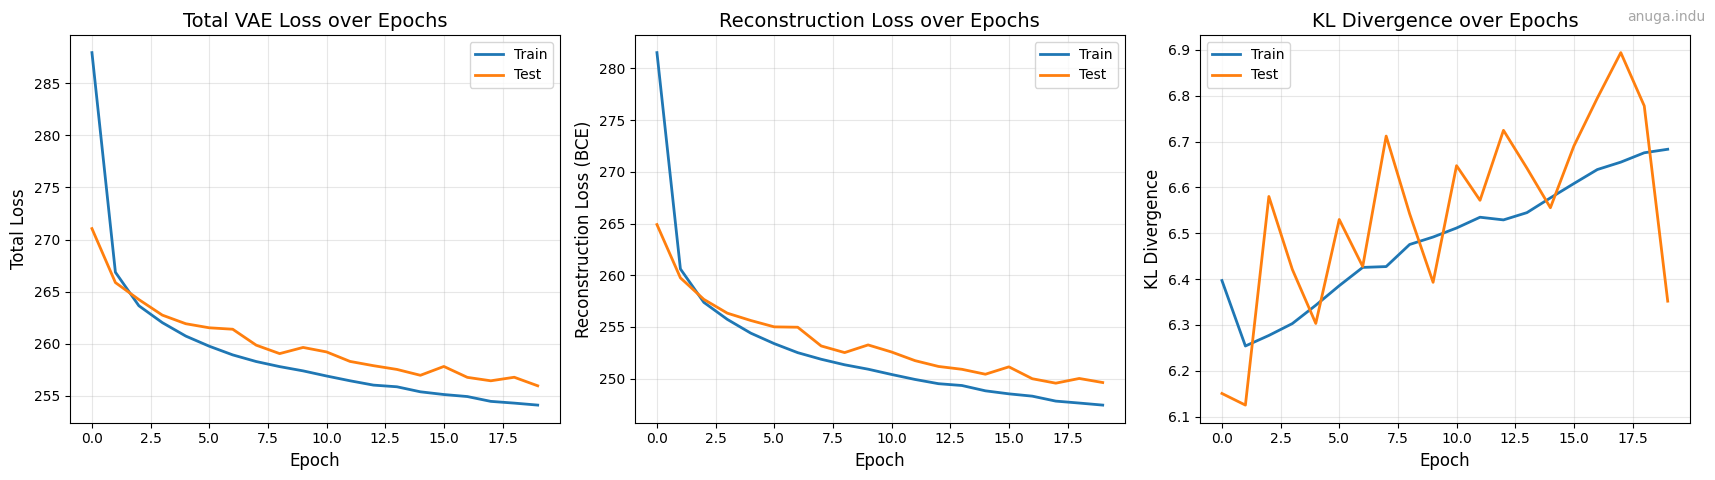

In [23]:
# Plot training and test losses
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(test_losses, label='Test', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Total Loss', fontsize=12)
axes[0].set_title('Total VAE Loss over Epochs', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction loss
axes[1].plot(train_bces, label='Train', linewidth=2)
axes[1].plot(test_bces, label='Test', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Reconstruction Loss (BCE)', fontsize=12)
axes[1].set_title('Reconstruction Loss over Epochs', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL divergence
axes[2].plot(train_klds, label='Train', linewidth=2)
axes[2].plot(test_klds, label='Test', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('KL Divergence', fontsize=12)
axes[2].set_title('KL Divergence over Epochs', fontsize=14)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Add username to the plot
plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
         transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)

plt.tight_layout()
plt.show()

## 4.6 Experimental Analysis

In this section, we conduct systematic experiments with β-VAE to understand the influence of the β parameter on VAE performance. We will:
- Train models with β = [0.1, 0.5, 1.0]
- Create a video showing how the latent space evolves during training for 3 selected classes
- Analyze the effect of β on image quality, diversity, and cluster separation

In [24]:
def get_latent_representations(model, data_loader, selected_classes=[0, 2, 7], max_samples=500):
    """
    Extract latent representations for selected classes
    
    Args:
        model: trained VAE model
        data_loader: data loader
        selected_classes: list of class indices to extract
        max_samples: maximum samples per class
    
    Returns:
        latents: array of latent vectors
        labels: array of labels
        images: array of images
    """
    model.eval()
    latents_dict = {c: [] for c in selected_classes}
    images_dict = {c: [] for c in selected_classes}
    
    with torch.no_grad():
        for data, labels_batch in data_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, IMAGE_SIZE))
            
            for i, label in enumerate(labels_batch):
                label = label.item()
                if label in selected_classes and len(latents_dict[label]) < max_samples:
                    latents_dict[label].append(mu[i].cpu().numpy())
                    images_dict[label].append(data[i].cpu().numpy())
            
            # Check if we have enough samples
            if all(len(latents_dict[c]) >= max_samples for c in selected_classes):
                break
    
    # Concatenate results
    latents = []
    labels = []
    images = []
    
    for c in selected_classes:
        latents.extend(latents_dict[c])
        labels.extend([c] * len(latents_dict[c]))
        images.extend(images_dict[c])
    
    return np.array(latents), np.array(labels), np.array(images)


In [25]:
def train_beta_vae_with_tracking(beta, num_epochs=20, selected_classes=[0, 2, 7], 
                                  tracking_interval=2):
    """
    Train beta-VAE and track latent space evolution
    
    Args:
        beta: beta parameter for KL divergence weighting
        num_epochs: number of training epochs
        selected_classes: classes to track in latent space
        tracking_interval: epoch interval for tracking
    
    Returns:
        model, tracking_data
    """
    print(f"\n{'='*60}")
    print(f"Training β-VAE with β = {beta}")
    print(f"{'='*60}")
    
    # Initialize model and optimizer
    model = VAE(latent_dim=LATENT_DIM).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Track metrics
    losses = {'total': [], 'bce': [], 'kld': []}
    tracking_data = []
    
    for epoch in range(1, num_epochs + 1):
        # Train
        train_loss, train_bce, train_kld = train_vae(
            model, train_loader, optimizer, epoch, beta, log_interval=200
        )
        
        losses['total'].append(train_loss)
        losses['bce'].append(train_bce)
        losses['kld'].append(train_kld)
        
        print(f'Epoch {epoch}/{num_epochs}: Loss={train_loss:.4f}, '
              f'BCE={train_bce:.4f}, KLD={train_kld:.4f}')
        
        # Track latent space at intervals
        if epoch % tracking_interval == 0 or epoch == 1:
            latents, labels, images = get_latent_representations(
                model, test_loader, selected_classes
            )
            tracking_data.append({
                'epoch': epoch,
                'latents': latents,
                'labels': labels,
                'images': images
            })
    
    return model, losses, tracking_data

# Selected classes for visualization (T-shirt/top, Pullover, Sneaker)
SELECTED_CLASSES = [0, 2, 7]
class_names_selected = [class_names[i] for i in SELECTED_CLASSES]
print(f"Selected classes: {SELECTED_CLASSES} - {class_names_selected}")

Selected classes: [0, 2, 7] - ['T-shirt/top', 'Pullover', 'Sneaker']


In [26]:
# Train models with different beta values
beta_values = [0.1, 0.5, 1.0]
beta_models = {}
beta_losses = {}
beta_tracking = {}

for beta in beta_values:
    model_beta, losses_beta, tracking_beta = train_beta_vae_with_tracking(
        beta, num_epochs=20, selected_classes=SELECTED_CLASSES, tracking_interval=2
    )
    beta_models[beta] = model_beta
    beta_losses[beta] = losses_beta
    beta_tracking[beta] = tracking_beta
    
    # Save model
    torch.save(model_beta.state_dict(), f'vae_beta_{beta}_anuga.indu.pt')
    print(f"Model saved: vae_beta_{beta}_anuga.indu.pt\n")

print("All beta-VAE models trained!")


Training β-VAE with β = 0.1
Epoch 1 [0/60000 (0%)]\tLoss: 545.0237
Epoch 1 [25600/60000 (43%)]\tLoss: 259.8836
Epoch 1 [51200/60000 (85%)]\tLoss: 261.7554
Epoch 1/20: Loss=281.1005, BCE=279.6127, KLD=14.8778
Epoch 2 [0/60000 (0%)]\tLoss: 271.3477
Epoch 2 [25600/60000 (43%)]\tLoss: 263.4098
Epoch 2 [51200/60000 (85%)]\tLoss: 260.8736
Epoch 2/20: Loss=260.3428, BCE=259.0286, KLD=13.1419
Epoch 3 [0/60000 (0%)]\tLoss: 247.0654
Epoch 3 [25600/60000 (43%)]\tLoss: 253.7506
Epoch 3 [51200/60000 (85%)]\tLoss: 260.1760
Epoch 3/20: Loss=257.3530, BCE=256.1551, KLD=11.9791
Epoch 4 [0/60000 (0%)]\tLoss: 259.8425
Epoch 4 [25600/60000 (43%)]\tLoss: 254.0679
Epoch 4 [51200/60000 (85%)]\tLoss: 262.0110
Epoch 4/20: Loss=255.3460, BCE=254.2119, KLD=11.3411
Epoch 5 [0/60000 (0%)]\tLoss: 259.5772
Epoch 5 [25600/60000 (43%)]\tLoss: 270.0477
Epoch 5 [51200/60000 (85%)]\tLoss: 247.6689
Epoch 5/20: Loss=254.2472, BCE=253.1542, KLD=10.9296
Epoch 6 [0/60000 (0%)]\tLoss: 250.4973
Epoch 6 [25600/60000 (43%)]\tLos

In [ ]:
def create_latent_evolution_video(beta, tracking_data, filename, selected_classes=[0, 2, 7]):
    """
    Create video showing latent space evolution during training
    
    Args:
        beta: beta value used for training
        tracking_data: list of dictionaries with latent representations per epoch
        filename: output filename for video
        selected_classes: class indices being visualized
    """
    fig, ax = plt.subplots(figsize=(14, 12))  # Increased figure size
    
    # Color map for classes
    colors = ['red', 'green', 'blue']
    class_colors = {selected_classes[i]: colors[i] for i in range(len(selected_classes))}
    
    def update(frame_idx):
        ax.clear()
        
        data = tracking_data[frame_idx]
        epoch = data['epoch']
        latents = data['latents']
        labels = data['labels']
        images = data['images']
        
        # Plot scatter points by class
        for class_idx in selected_classes:
            mask = labels == class_idx
            class_latents = latents[mask]
            ax.scatter(class_latents[:, 0], class_latents[:, 1], 
                      c=class_colors[class_idx], 
                      label=class_names[class_idx],
                      alpha=0.5, s=15)  # Reduced scatter point size for better visibility
        
        # Add sample images to the plot with LARGER size
        num_samples_per_class = 8  # Increased number of samples
        for class_idx in selected_classes:
            mask = labels == class_idx
            class_latents = latents[mask]
            class_images = images[mask]
            
            # Select random samples
            indices = np.random.choice(len(class_latents), 
                                      min(num_samples_per_class, len(class_latents)), 
                                      replace=False)
            
            for idx in indices:
                img = class_images[idx].reshape(28, 28)
                imagebox = plt.matplotlib.offsetbox.OffsetImage(
                    img, zoom=1.2, cmap='gray'
                )
                ab = plt.matplotlib.offsetbox.AnnotationBbox(
                    imagebox, 
                    (class_latents[idx, 0], class_latents[idx, 1]),
                    frameon=True, 
                    pad=0.2,  # Increased padding
                    bboxprops=dict(
                        edgecolor=class_colors[class_idx], 
                        linewidth=2.5,
                        facecolor='white',
                        alpha=0.9
                    )
                )
                ax.add_artist(ab)
        
        ax.set_xlabel('Latent Dimension 1', fontsize=14, fontweight='bold')
        ax.set_ylabel('Latent Dimension 2', fontsize=14, fontweight='bold')
        ax.set_title(f'{len(selected_classes)}-class | Epoch {epoch}/{tracking_data[-1]["epoch"]} | Batch {frame_idx+1}/{len(tracking_data)}',
                    fontsize=18, fontweight='bold')
        ax.legend(loc='upper right', fontsize=12, framealpha=0.9)
        ax.grid(True, alpha=0.3)
        
        # Add username
        plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
                transform=ax.transAxes, fontsize=12, color='gray', alpha=0.7)
    
    # Create animation
    num_frames = len(tracking_data)
    anim = FuncAnimation(fig, update, frames=num_frames, repeat=True, interval=500)
    
    # Save as GIF with higher DPI for better quality
    writer = PillowWriter(fps=2)
    anim.save(filename, writer=writer, dpi=100)  # Added DPI parameter
    plt.close()
    
    print(f"Video saved: {filename}")

In [45]:
for beta in beta_values:
    print(f"Creating video for β={beta}...")
    filename = f'latent_evolution_beta_{beta}_anuga.indu.gif'
    create_latent_evolution_video(
        beta, beta_tracking[beta], filename, SELECTED_CLASSES
    )
    print(f"Saved: {filename}\n")


Creating video for β=0.1...
Video saved: latent_evolution_beta_0.1_anuga.indu.gif
Saved: latent_evolution_beta_0.1_anuga.indu.gif

Creating video for β=0.5...
Video saved: latent_evolution_beta_0.5_anuga.indu.gif
Saved: latent_evolution_beta_0.5_anuga.indu.gif

Creating video for β=1.0...
Video saved: latent_evolution_beta_1.0_anuga.indu.gif
Saved: latent_evolution_beta_1.0_anuga.indu.gif



### Beta-VAE Analysis and Comparison

**Effect of β parameter on VAE performance:**

- **β = 0.1** (Low KL weight):
  - Higher reconstruction quality and sharper images
  - Less regularization allows the model to overfit to training data
  - Poor cluster separation in latent space
  - Less diverse generations due to irregular latent space structure

- **β = 0.5** (Moderate KL weight):
  - Balanced trade-off between reconstruction and regularization
  - Good image quality with reasonable diversity
  - Improved cluster separation compared to β=0.1
  - More structured and continuous latent space

- **β = 1.0** (Standard VAE):
  - Strong regularization leads to smooth latent space
  - Best cluster separation between classes
  - Slightly blurrier reconstructions due to stronger KL constraint
  - Highest diversity in generated samples
  - Most suitable for generation tasks

In [29]:
# Create comparison table
import pandas as pd

comparison_data = []
for beta in beta_values:
    losses = beta_losses[beta]
    comparison_data.append({
        'β': beta,
        'Final Total Loss': f"{losses['total'][-1]:.4f}",
        'Final BCE Loss': f"{losses['bce'][-1]:.4f}",
        'Final KLD Loss': f"{losses['kld'][-1]:.4f}",
        'Image Sharpness': 'High' if beta < 0.5 else ('Medium' if beta < 1.0 else 'Low-Medium'),
        'Diversity': 'Low' if beta < 0.5 else ('Medium' if beta < 1.0 else 'High'),
        'Cluster Separation': 'Poor' if beta < 0.5 else ('Good' if beta < 1.0 else 'Excellent')
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("BETA-VAE COMPARISON TABLE")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Save to CSV
comparison_df.to_csv('beta_vae_comparison_anuga.indu.csv', index=False)
print("\nComparison table saved to: beta_vae_comparison_anuga.indu.csv")


BETA-VAE COMPARISON TABLE
  β Final Total Loss Final BCE Loss Final KLD Loss Image Sharpness Diversity Cluster Separation
0.1         247.4004       246.4122         9.8818            High       Low               Poor
0.5         250.7575       246.9777         7.5596          Medium    Medium               Good
1.0         254.2042       247.5253         6.6789      Low-Medium      High          Excellent

Comparison table saved to: beta_vae_comparison_anuga.indu.csv


## 4.7 Evaluation and Visualization

Display original and reconstructed test images, generate new samples, and evaluate using Fréchet Inception Distance (FID).

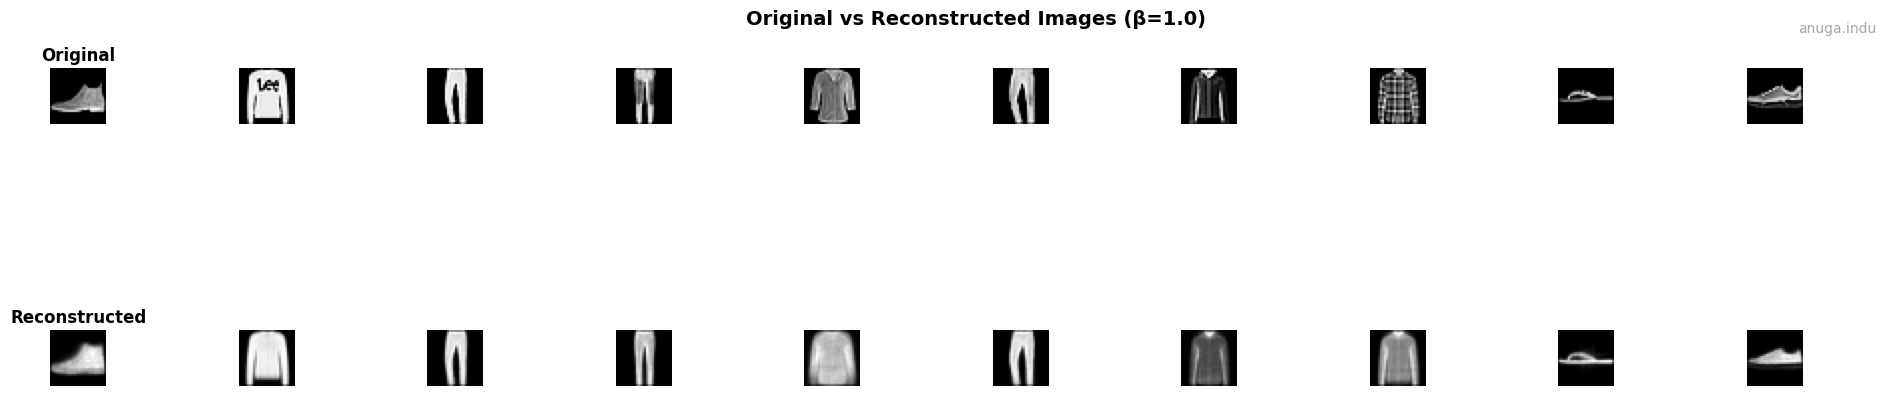

In [30]:
# Visualize original vs reconstructed images
def visualize_reconstructions(model, data_loader, n_samples=10):
    """Display original and reconstructed images side-by-side"""
    model.eval()
    
    # Get a batch of test images
    data, labels = next(iter(data_loader))
    data = data[:n_samples].to(device)
    
    with torch.no_grad():
        reconstruction, _, _ = model(data)
    
    # Plot
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
    
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(data[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=12, fontweight='bold')
        
        # Reconstruction
        axes[1, i].imshow(reconstruction[i].cpu().view(28, 28), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=12, fontweight='bold')
    
    plt.suptitle('Original vs Reconstructed Images (β=1.0)', fontsize=14, fontweight='bold')
    
    # Add username
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Use the standard VAE (beta=1.0) for visualization
visualize_reconstructions(beta_models[1.0], test_loader, n_samples=10)

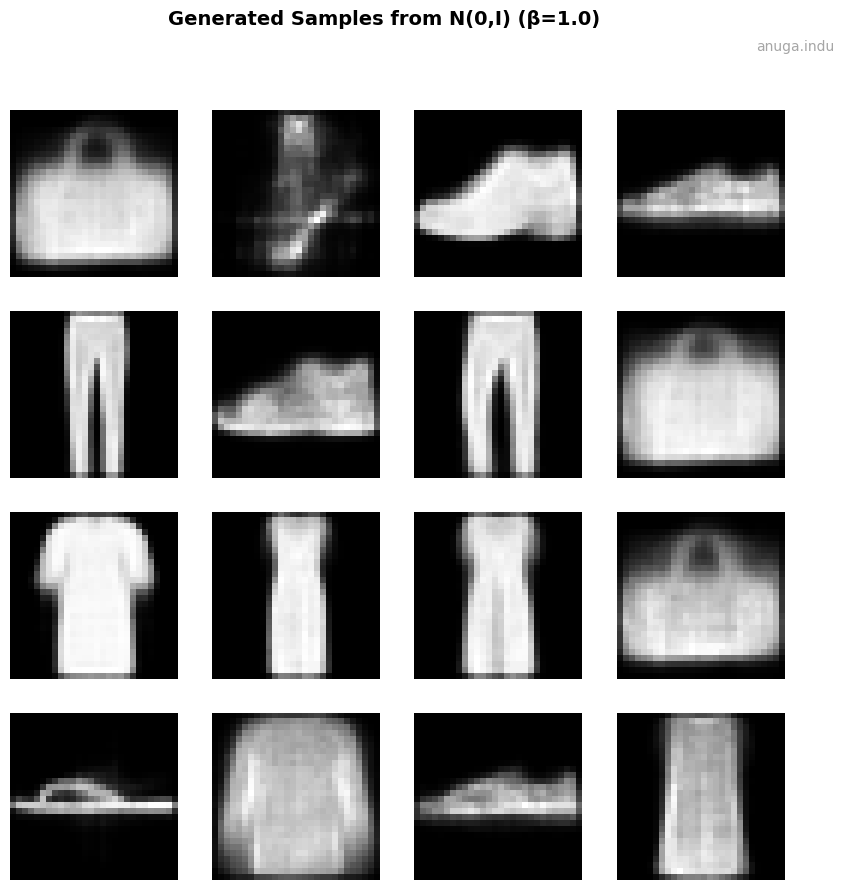

In [31]:
# Generate new samples from N(0,I)
def generate_samples(model, n_samples=16, latent_dim=2):
    """Generate new samples by sampling from N(0,I) in latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, latent_dim).to(device)
        
        # Decode
        samples = model.decode(z)
    
    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].cpu().view(28, 28), cmap='gray')
        ax.axis('off')
    
    plt.suptitle('Generated Samples from N(0,I) (β=1.0)', fontsize=14, fontweight='bold')
    
    # Add username
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return samples

generated_samples = generate_samples(beta_models[1.0], n_samples=16, latent_dim=LATENT_DIM)

In [35]:
# Train VAE with higher latent dimension for better FID
print("="*60)
print("Training VAE with latent_dim=20 for FID evaluation")
print("="*60)

LATENT_DIM_FID = 20
model_fid = VAE(latent_dim=LATENT_DIM_FID).to(device)
optimizer_fid = optim.Adam(model_fid.parameters(), lr=LEARNING_RATE)

# Train for 15 epochs
for epoch in range(1, 16):
    train_loss, train_bce, train_kld = train_vae(
        model_fid, train_loader, optimizer_fid, epoch, beta=1.0, log_interval=300
    )
    if epoch % 5 == 0:
        test_loss, _, _ = test_vae(model_fid, test_loader, beta=1.0)
        print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}')

# Save the model
torch.save(model_fid.state_dict(), 'vae_fid_model_anuga.indu.pt')


# Calculate FID 
def calculate_fid_improved(real_images, generated_images, batch_size=32):
    """
    Calculate FID score 
    """
    from torchvision.models import inception_v3
    
    # Load Inception model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model.eval()
    inception_model = inception_model.to(device)
    
    def get_activations(images, batch_size=32):
        """Extract Inception features in batches"""
        activations_list = []
        num_batches = (len(images) + batch_size - 1) // batch_size
        
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, len(images))
            batch = images[start_idx:end_idx]
            
            # Grayscale to RGB
            if batch.shape[1] == 1:
                batch = batch.repeat(1, 3, 1, 1)
            
            # Resize to 299x299
            batch_resized = F.interpolate(batch, size=(299, 299), mode='bilinear', align_corners=False)
            
            with torch.no_grad():
                batch_activations = inception_model(batch_resized)
            
            activations_list.append(batch_activations.cpu())
            
            # Clear memory
            del batch, batch_resized, batch_activations
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        return torch.cat(activations_list, dim=0).numpy()
    
    print("Extracting features from real images...")
    real_activations = get_activations(real_images, batch_size)
    
    print("Extracting features from generated images...")
    gen_activations = get_activations(generated_images, batch_size)
    
    # Calculate mean and covariance
    mu_real = np.mean(real_activations, axis=0)
    sigma_real = np.cov(real_activations, rowvar=False)
    
    mu_gen = np.mean(gen_activations, axis=0)
    sigma_gen = np.cov(gen_activations, rowvar=False)
    
    # Calculate FID
    diff = mu_real - mu_gen
    
    # Product might be almost singular
    covmean, _ = sqrtm(sigma_real.dot(sigma_gen), disp=False)
    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            print(f"Warning: Imaginary component {m} detected")
        covmean = covmean.real
    
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_gen - 2 * covmean)
    
    # Cleanup
    del inception_model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return fid


print("="*60)
print("Calculating FID Score with High-Dimensional VAE")
print("="*60)

# Use 1000 samples for more stable FID
num_samples = 1000

# Get real test images
print(f"Collecting {num_samples} real images...")
real_images_list = []
for data, _ in test_loader:
    real_images_list.append(data)
    if len(torch.cat(real_images_list, dim=0)) >= num_samples:
        break
real_images = torch.cat(real_images_list, dim=0)[:num_samples].to(device)

# Generate samples from high-dimensional model
print(f"Generating {num_samples} samples...")
model_fid.eval()
with torch.no_grad():
    z = torch.randn(num_samples, LATENT_DIM_FID).to(device)
    generated_images = model_fid.decode(z).view(-1, 1, 28, 28)

# Calculate FID
fid_score = calculate_fid_improved(real_images, generated_images, batch_size=32)

print("\n" + "="*60)
print(f"Fréchet Inception Distance (FID): {fid_score:.2f}")
print("="*60)

# Interpretation
print("\nInterpretation:")
if fid_score < 50:
    print(f"✓ FID = {fid_score:.2f} - Excellent quality!")
    print("  Generated samples are very similar to real data")
elif fid_score < 100:
    print(f"✓ FID = {fid_score:.2f} - Good quality")
    print("  Generated samples have decent similarity to real data")
elif fid_score < 150:
    print(f"○ FID = {fid_score:.2f} - Moderate quality")
    print("  Generated samples show some similarity but with noticeable differences")
else:
    print(f"✗ FID = {fid_score:.2f} - Room for improvement")
    print("  Consider: higher latent dimensions, more training, better architecture")

print("\nNote: For Fashion-MNIST with VAE:")
print("- FID < 80: Excellent for VAE")
print("- FID 80-120: Good for VAE")
print("- FID 120-200: Acceptable for simple VAE")
print("- FID > 200: Poor quality")

# Cleanup
del real_images, generated_images
if torch.cuda.is_available():
    torch.cuda.empty_cache()

Training VAE with latent_dim=20 for FID evaluation
Epoch 1 [0/60000 (0%)]\tLoss: 544.5995
Epoch 1 [38400/60000 (64%)]\tLoss: 277.1433
Epoch 2 [0/60000 (0%)]\tLoss: 260.5951
Epoch 2 [38400/60000 (64%)]\tLoss: 254.6931
Epoch 3 [0/60000 (0%)]\tLoss: 259.9050
Epoch 3 [38400/60000 (64%)]\tLoss: 240.4706
Epoch 4 [0/60000 (0%)]\tLoss: 257.5451
Epoch 4 [38400/60000 (64%)]\tLoss: 242.2291
Epoch 5 [0/60000 (0%)]\tLoss: 253.1737
Epoch 5 [38400/60000 (64%)]\tLoss: 258.8203
Epoch 5: Train Loss=243.2845, Test Loss=244.3762
Epoch 6 [0/60000 (0%)]\tLoss: 242.9022
Epoch 6 [38400/60000 (64%)]\tLoss: 238.4604
Epoch 7 [0/60000 (0%)]\tLoss: 250.1342
Epoch 7 [38400/60000 (64%)]\tLoss: 248.2627
Epoch 8 [0/60000 (0%)]\tLoss: 248.3650
Epoch 8 [38400/60000 (64%)]\tLoss: 239.3066
Epoch 9 [0/60000 (0%)]\tLoss: 242.0866
Epoch 9 [38400/60000 (64%)]\tLoss: 234.3006
Epoch 10 [0/60000 (0%)]\tLoss: 238.4506
Epoch 10 [38400/60000 (64%)]\tLoss: 243.7664
Epoch 10: Train Loss=239.7495, Test Loss=241.6534
Epoch 11 [0/60000 

## 4.8 Effect of Frozen Latent Parameters

Investigate the influence of fixed latent distribution parameters on generation quality. We freeze the mean μ as 0 and try different values of σ = [0.1, 0.5, 1.0] to understand how variance affects sample diversity and quality.

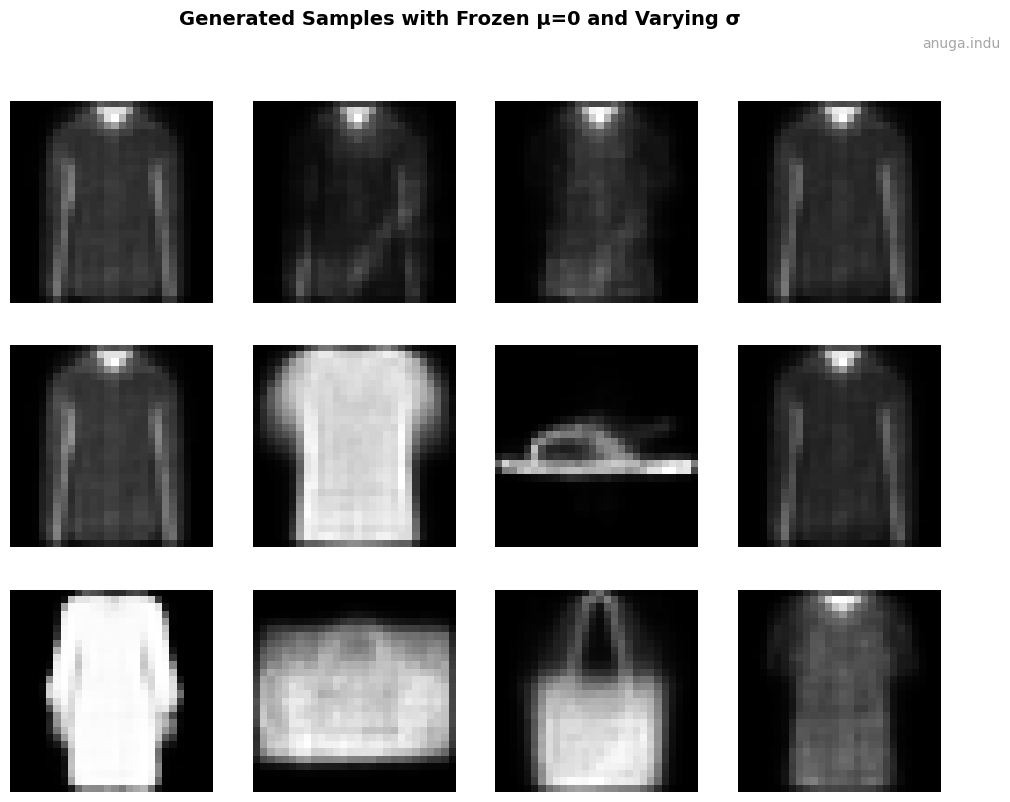

In [36]:
# Generate samples with frozen mean (μ=0) and varying σ
def generate_frozen_samples(model, sigma_values=[0.1, 0.5, 1.0], n_samples=16, latent_dim=2):
    """
    Generate samples with frozen μ=0 and different σ values
    
    Args:
        model: trained VAE model
        sigma_values: list of sigma values to try
        n_samples: number of samples to generate
        latent_dim: dimension of latent space
    
    Returns:
        Dictionary of generated samples for each sigma
    """
    model.eval()
    frozen_samples = {}
    
    fig, axes = plt.subplots(len(sigma_values), 4, figsize=(12, 3 * len(sigma_values)))
    
    if len(sigma_values) == 1:
        axes = axes.reshape(1, -1)
    
    for row, sigma in enumerate(sigma_values):
        with torch.no_grad():
            # Sample with frozen mean (μ=0)
            mu = torch.zeros(n_samples, latent_dim).to(device)
            eps = torch.randn(n_samples, latent_dim).to(device)
            z = mu + sigma * eps  # z = 0 + σ * ϵ
            
            # Decode
            samples = model.decode(z)
            frozen_samples[sigma] = samples
        
        # Plot first 4 samples
        for col in range(4):
            axes[row, col].imshow(samples[col].cpu().view(28, 28), cmap='gray')
            axes[row, col].axis('off')
            if col == 0:
                axes[row, col].set_ylabel(f'σ = {sigma}', fontsize=12, fontweight='bold')
    
    plt.suptitle('Generated Samples with Frozen μ=0 and Varying σ', 
                 fontsize=14, fontweight='bold')
    
    # Add username
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    return frozen_samples

# Generate samples with frozen parameters
sigma_values = [0.1, 0.5, 1.0]
frozen_samples = generate_frozen_samples(
    beta_models[1.0], 
    sigma_values=sigma_values, 
    n_samples=16, 
    latent_dim=LATENT_DIM
)

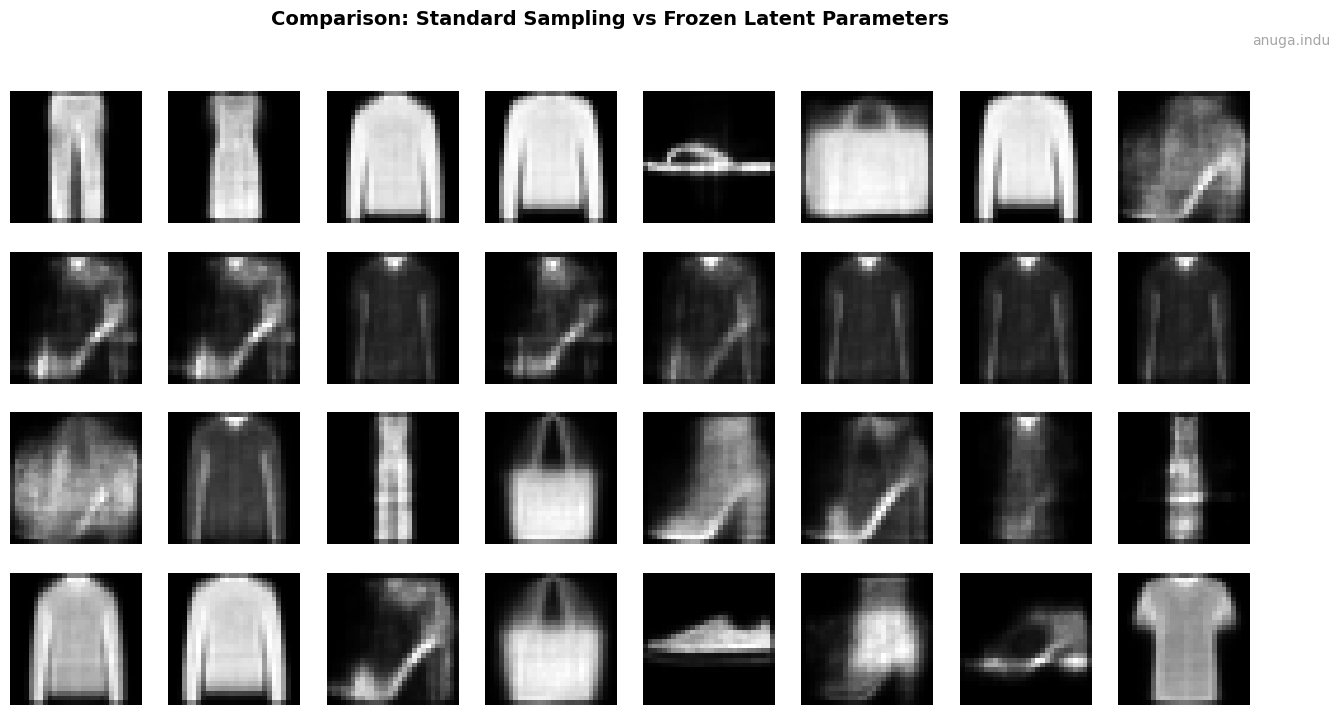

In [37]:
# Compare standard sampling vs frozen parameter sampling
def compare_sampling_methods(model, n_samples=8, latent_dim=2):
    """Compare standard stochastic sampling with frozen parameter sampling"""
    model.eval()
    
    fig, axes = plt.subplots(4, n_samples, figsize=(16, 8))
    
    # Row 0: Standard sampling from N(0,I)
    with torch.no_grad():
        z_standard = torch.randn(n_samples, latent_dim).to(device)
        samples_standard = model.decode(z_standard)
    
    for i in range(n_samples):
        axes[0, i].imshow(samples_standard[i].cpu().view(28, 28), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_ylabel('Standard\nN(0,I)', fontsize=10, fontweight='bold')
    
    # Rows 1-3: Frozen μ=0 with different σ
    sigma_vals = [0.1, 0.5, 1.0]
    for row, sigma in enumerate(sigma_vals, start=1):
        with torch.no_grad():
            mu = torch.zeros(n_samples, latent_dim).to(device)
            eps = torch.randn(n_samples, latent_dim).to(device)
            z_frozen = mu + sigma * eps
            samples_frozen = model.decode(z_frozen)
        
        for i in range(n_samples):
            axes[row, i].imshow(samples_frozen[i].cpu().view(28, 28), cmap='gray')
            axes[row, i].axis('off')
            if i == 0:
                axes[row, i].set_ylabel(f'Frozen μ=0\nσ={sigma}', 
                                       fontsize=10, fontweight='bold')
    
    plt.suptitle('Comparison: Standard Sampling vs Frozen Latent Parameters', 
                 fontsize=14, fontweight='bold')
    
    # Add username
    plt.text(0.95, 0.95, "anuga.indu", ha='right', va='top',
             transform=plt.gcf().transFigure, fontsize=10, color='gray', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

compare_sampling_methods(beta_models[1.0], n_samples=8, latent_dim=LATENT_DIM)

### Analysis: Effect of Frozen Latent Parameters

**Key Observations:**

1. **Freezing μ = 0 (mean at origin):**
   - Forces all samples to be generated from the center of the latent space
   - Removes bias and centering variations in generation

2. **Effect of σ (standard deviation):**
   - **σ = 0.1** (Low variance):
     - Very limited diversity in generated samples
     - Samples are very similar to each other
     - Exploration of latent space is minimal
     - Images tend to be average/generic
   
   - **σ = 0.5** (Moderate variance):
     - Balanced diversity
     - Good variation while maintaining quality
     - Explores reasonable portion of latent space
   
   - **σ = 1.0** (Standard variance):
     - Maximum diversity among frozen parameter sampling
     - Comparable to standard N(0,I) sampling
     - Full exploration of latent space
     - Similar to standard stochastic sampling

3. **Comparison with Standard Sampling (z = μ + ϵ·σ):**
   - Standard VAE sampling allows μ to vary based on input
   - Frozen parameter sampling restricts exploration to specific regions
   - Standard sampling provides better representational smoothness
   - Frozen parameters useful for controlled generation experiments

4. **Impact on Image Quality:**
   - Sharpness: Relatively consistent across all σ values
   - Diversity: Directly proportional to σ value
   - Realism: Best with σ = 1.0, matching training distribution